In [16]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../")
from utils.io import read_parameters
from src.plot_trajectories import normalize_speed
from src.plot_trajectories import plot_trajectories

cmap = matplotlib.colormaps["seismic_r"]

In [17]:
# read parameters and key file

parameter_file  = "../local/parameters.yml"
parameters = read_parameters(parameter_file)       

key_file_path = parameters["key_file"]
key_file = pd.read_csv(key_file_path)

print("key file columns:", key_file.columns)
print("key file conditions:", key_file["condition"].unique())
print(display(key_file))

key file columns: Index(['experimentID', 'filename', 'color', 'mosaic', 'treatment', 'condition',
       'date'],
      dtype='object')
key file conditions: ['mosaic_siScr_siScr' 'mosaic_siScr_siCdc42' 'mosaic_siScr_siRac1']


,experimentID,filename,color,mosaic,treatment,condition,date
0,240112_siScr_mosaic,/siScr_mosaic/240112_siScr_green.csv,green,1,siScr,mosaic_siScr_siScr,240112
1,240112_siScr_mosaic,/siScr_mosaic/240112_siScr_red.csv,red,1,siScr,mosaic_siScr_siScr,240112
2,240301_siScr_1_mosaic,/siScr_mosaic/240301_siScr_green_1.csv,green,1,siScr,mosaic_siScr_siScr,240301
3,240301_siScr_1_mosaic,/siScr_mosaic/240301_siScr_red_1.csv,red,1,siScr,mosaic_siScr_siScr,240301
4,240301_siScr_2_mosaic,/siScr_mosaic/240301_siScr_green_2.csv,green,1,siScr,mosaic_siScr_siScr,240301
5,240301_siScr_2_mosaic,/siScr_mosaic/240301_siScr_red_2.csv,red,1,siScr,mosaic_siScr_siScr,240301
6,240315_siScr_mosaic,/siScr_mosaic/240315_siScr_green.csv,green,1,siScr,mosaic_siScr_siScr,240315
7,240315_siScr_mosaic,/siScr_mosaic/240315_siScr_red.csv,red,1,siScr,mosaic_siScr_siScr,240315
8,240119_siScr_siCdc42,/siScr_siCdc42/240119_siScr_green.csv,green,1,siScr,mosaic_siScr_siCdc42,240119
9,240119_siScr_siCdc42,/siScr_siCdc42/240119_siCDC42_red.csv,red,1,siCdc42,mosaic_siScr_siCdc42,240119


None


In [18]:
# create output folder

output_folder = parameters["output_folder"]
print("Output folder:", output_folder)

data_folder = output_folder + "/tracking_data/"

subfolder = "trajectory_plots"
if not os.path.exists(output_folder + "/" + subfolder):
    os.mkdir(output_folder + "/" + subfolder)

experimentID = "240112_siScr_mosaic"

experiment_df = key_file[key_file["experimentID"] == experimentID]

number_of_tracks_per_condition = parameters["number_of_tracks_per_condition"]

observation_time = parameters["observation_time"]

# limits for min velocity and max velocity in um/h used for the color map
min_vel_lim = -30.0 # um/h
max_vel_lim = 30.0 # um/h

# extend in microns of the coordinate system used for plotting, 
# range is [0, max_x] in x direction and [0, max_y] in y direction
max_x = 1200.0 # um
max_y = 1200.0 # um

list_of_files = []


# uncomment this if you want to select specific files
for index, row in experiment_df.iterrows():
    condition = row["condition"]
    treatment = row["treatment"]
    print("condition:", condition)

    # read tracking data
    tracking_file = "tracking_data_%s_%s_%s.csv" % (treatment, row["color"], row["experimentID"])
    tracking_data_path = data_folder + tracking_file

    list_of_files.append(tracking_data_path)

# if you want to plot a specific file for example "tracking_data_1.csv", uncomment the following line and specify the file name:
# list_of_files = ["tracking_data_1.csv"]

print("Files to be analysed")
list_of_files



Output folder: /media/fjodor/Elephant/Dropbox/MDC_Projects/manuscript_cdc42/mosaic_2D/output/
condition: mosaic_siScr_siScr
condition: mosaic_siScr_siScr
Files to be analysed


['/media/fjodor/Elephant/Dropbox/MDC_Projects/manuscript_cdc42/mosaic_2D/output//tracking_data/tracking_data_siScr_green_240112_siScr_mosaic.csv',
 '/media/fjodor/Elephant/Dropbox/MDC_Projects/manuscript_cdc42/mosaic_2D/output//tracking_data/tracking_data_siScr_red_240112_siScr_mosaic.csv']

Available tracks: 697
Available tracks: 400


NameError: name 'track_counter' is not defined

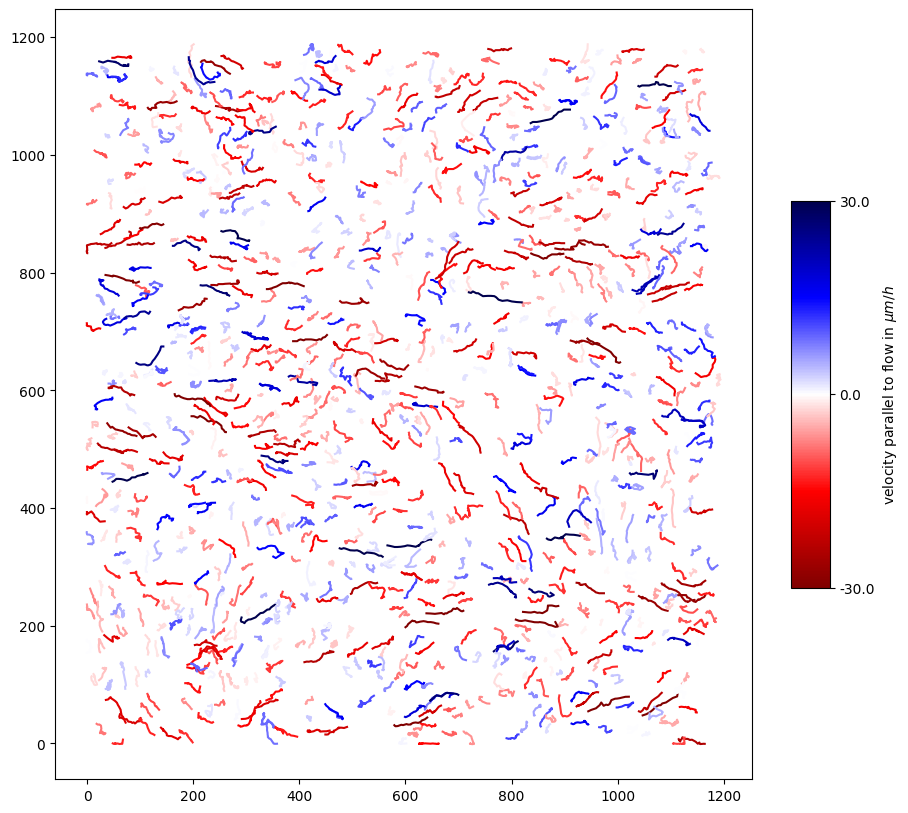

In [22]:
max_vel = 0
min_vel = 0
number_of_tracks = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

obs_time_length_frames = observation_time[1] - observation_time[0]

for tracking_data_path in list_of_files:

    tracking_data = pd.read_csv(tracking_data_path, low_memory=False)

    observation_period_df = tracking_data[tracking_data["FRAME"] <= observation_time[1]]
    observation_period_df = observation_period_df[observation_period_df["FRAME"] >= observation_time[0]]

    # Get the first frame of each track
    tracks_start = observation_period_df[observation_period_df["FRAME"] == observation_time[0]]

    #print("tracking data columns:", tracking_data.columns)
    #print("tracking data shape:", tracking_data.shape)
    #print(display(tracking_data))

    frame_end_point = observation_time[1]
    if parameters["allow_tracks_shorter_than_observation_time"] == True:
        if obs_time_length_frames > parameters["min_track_length"]:
            frame_end_point = observation_time[0] + parameters["min_track_length"]

    # Assign tracks_end using the determined frame
    tracks_end = observation_period_df[observation_period_df["FRAME"] == frame_end_point]

    track_ids_start = np.array(tracks_start["TRACK_ID"].unique())
    track_ids_end = np.array(tracks_end["TRACK_ID"].unique())

    unique_common_track_ids = np.intersect1d(track_ids_start, track_ids_end)

    trackID_list = np.unique(unique_common_track_ids)
   
    print("Available tracks: %s" % len(trackID_list))

    number_of_tracks += len(trackID_list)

    # normalize speed
    #tracking_data = normalize_speed(tracking_data)

    # plot trajectories
    
    for track_id in trackID_list:

        single_track_df = observation_period_df[observation_period_df["TRACK_ID"] == track_id].copy()


        start_frame = single_track_df["FRAME"].min()
        end_frame = single_track_df["FRAME"].max()
        delta_frame = end_frame - start_frame

        delta_hour = delta_frame/parameters["frames_per_hour"]

        row_start = single_track_df[single_track_df["FRAME"] == start_frame]
        row_end = single_track_df[single_track_df["FRAME"] == end_frame]

        start_x = np.array(row_start["POSITION_X"])[0]
        start_y = np.array(row_start["POSITION_Y"])[0]
        end_x = np.array(row_end["POSITION_X"])[0]
        end_y = np.array(row_end["POSITION_Y"])[0]
        delta_x = end_x - start_x
        delta_y = end_y - start_y

        #total_dist_per_file += np.sqrt(delta_x**2 + delta_y**2)

        #center_x += delta_x
        #center_y += delta_y

        #center_per_file_x += delta_x
        #center_per_file_y += delta_y

        rel_vel = normalize_speed(delta_x/delta_hour, min_vel_lim, max_vel_lim)

        if delta_x/delta_hour > max_vel:
            max_vel = delta_x/delta_hour
        if delta_x/delta_hour < min_vel:
            min_vel = delta_x/delta_hour

        ax.plot(single_track_df["POSITION_X"],single_track_df["POSITION_Y"], color = cmap(rel_vel))
        #ax.plot([delta_x],[delta_y], color = "black", marker = "o", alpha=0.5) 

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax, label='velocity parallel to flow in $\mu m/h$', aspect=10, fraction = 0.05)
cbar.set_ticks([0.0,0.5,1.0])

# Optionally, set tick labels if you want to customize them further
mid_vel = (max_vel_lim + min_vel_lim)/2
cbar.set_ticklabels([min_vel_lim, mid_vel, max_vel_lim])

print("%s tracks in total" % number_of_tracks)
print("max velocity: ", max_vel, " um/h: ", " min velocity : ", min_vel, " um/h (parallel to flow)")

# set figure properties
ax.set_xlim(0,max_x)
ax.set_ylim(0,max_y)
ax.axhline(0, color = "red", linestyle = "--")
ax.axvline(0, color = "red", linestyle = "--")
ax.set_xlabel("x in $\mu m$")
ax.set_ylabel("y in $\mu m$")
ax.set_aspect(1)
plt.tight_layout()
plt.savefig(experimentID + ".png")
plt.savefig(experimentID + ".pdf")
    #plt.savefig(output_folder + "/" + subfolder + "/" + condition + ".png")
    #plt.close()

In [ ]:
key_select = key_file[key_file["condition"] == condition]
key_select = key_select[key_select["treatment"] == treatment] 
#key_select = key_select[key_select["color"] == color]
print(key_select)

number_of_tracks_per_file = int(number_of_tracks_per_condition/len(key_select.index))
print("sample %s tracks per file" % number_of_tracks_per_file)

track_counter = 0
center_x = 0
center_y = 0
max_vel = 0
min_vel = 0

fig, ax = plt.subplots(figsize=(9,9))

obs_time_length_frames = observation_time[1] - observation_time[0]

for index, row in key_select.iterrows():

    tracking_file = "tracking_data_%s_%s_%s.csv" % (treatment, row["color"], row["experimentID"])
                
    data = pd.read_csv(data_folder+ tracking_file, low_memory=False)

    observation_period_df = data[data["FRAME"] <= observation_time[1]]
    observation_period_df = observation_period_df[observation_period_df["FRAME"] >= observation_time[0]]

    # Get the first frame of each track
    tracks_start = observation_period_df[observation_period_df["FRAME"] == observation_time[0]]
    
    # determine the min end point of the tracks
    # in case "allow_tracks_shorter_than_observation_time" in the parameters file is set to True
    # -> the min required track length is the min of 'obs_time_length_frames' and 'min_track_length'
    # in case "allow_tracks_shorter_than_observation_time" in the parameters file is set to False
    # -> the end point of each trajectory is the end of the observation time 

    frame_end_point = observation_time[1]
    if parameters["allow_tracks_shorter_than_observation_time"] == True:
        if obs_time_length_frames > parameters["min_track_length"]:
            frame_end_point = observation_time[0] + parameters["min_track_length"]

    # Assign tracks_end using the determined frame
    tracks_end = observation_period_df[observation_period_df["FRAME"] == frame_end_point]

    track_ids_start = np.array(tracks_start["TRACK_ID"].unique())
    track_ids_end = np.array(tracks_end["TRACK_ID"].unique())

    unique_common_track_ids = np.intersect1d(track_ids_start, track_ids_end)

    trackID_list = np.unique(unique_common_track_ids)
   
    print("Available tracks: %s" % len(trackID_list))
    trackID_list = np.random.choice(trackID_list, number_of_tracks_per_file)

    print("sampled %s tracks for file %s" % (len(trackID_list),tracking_file))
    track_counter += len(trackID_list)

    center_per_file_x = 0.0
    center_per_file_y = 0.0
    total_dist_per_file = 0.0

    for track_id in trackID_list:
        single_track_df = observation_period_df[observation_period_df["TRACK_ID"] == track_id].copy()

        start_frame = single_track_df["FRAME"].min()
        end_frame = single_track_df["FRAME"].max()
        delta_frame = end_frame - start_frame

        delta_hour = delta_frame/parameters["frames_per_hour"]

        row_start = single_track_df[single_track_df["FRAME"] == start_frame]
        row_end = single_track_df[single_track_df["FRAME"] == end_frame]

        start_x = np.array(row_start["POSITION_X"])[0]
        start_y = np.array(row_start["POSITION_Y"])[0]
        end_x = np.array(row_end["POSITION_X"])[0]
        end_y = np.array(row_end["POSITION_Y"])[0]
        delta_x = end_x - start_x
        delta_y = end_y - start_y

        single_track_df["X_from_origin"] = single_track_df["POSITION_X"] - start_x
        single_track_df["Y_from_origin"] = single_track_df["POSITION_Y"] - start_y

        total_dist_per_file += np.sqrt(delta_x**2 + delta_y**2)

        center_x += delta_x
        center_y += delta_y

        center_per_file_x += delta_x
        center_per_file_y += delta_y

        rel_vel = normalize_speed(delta_x/delta_hour, min_vel_lim, max_vel_lim)

        if delta_x/delta_hour > max_vel:
            max_vel = delta_x/delta_hour
        if delta_x/delta_hour < min_vel:
            min_vel = delta_x/delta_hour

        ax.plot(single_track_df["X_from_origin"],single_track_df["Y_from_origin"], color = cmap(rel_vel))
        ax.plot([delta_x],[delta_y], color = "black", marker = "o", alpha=0.5) 

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax, label='velocity parallel to flow in $\mu m/h$', aspect=10, fraction = 0.05)
cbar.set_ticks([0.0,0.5,1.0])

# Optionally, set tick labels if you want to customize them further
mid_vel = (max_vel_lim + min_vel_lim)/2
cbar.set_ticklabels([min_vel_lim, mid_vel, max_vel_lim])

print("sampled %s tracks in total" % track_counter)
print("max velocity: ", max_vel, " um/h: ", " min velocity : ", min_vel, " um/h (parallel to flow)")

# set figure properties
ax.set_xlim(-max_x,max_y)
ax.set_ylim(-max_x,max_y)
ax.axhline(0, color = "red", linestyle = "--")
ax.axvline(0, color = "red", linestyle = "--")
title = ("Treatment: " + treatment 
         + "sampled tracks: " + str(track_counter)
         + " , min/max velocity parallel to flow: " + str(np.round(min_vel,3)) 
         + "/" + str(np.round(max_vel,3)) + " $\mu m/h$" )
ax.set_title(title)
ax.set_xlabel("$\Delta x$ in $\mu m$")
ax.set_ylabel("$\Delta y$ in $\mu m$")
ax.set_aspect(1)
plt.tight_layout()

# save and show plot
plt.savefig(output_folder + "/" + subfolder + "/" + "trajectories_" + condition + "_" + color + ".pdf")
plt.savefig(output_folder + "/" + subfolder + "/" + "trajectories_" + condition + "_" + color + ".png")
plt.show()